In [2]:
import os, time
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
from scipy.linalg import expm, eig, logm
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, BasicAer, execute, IBMQ
from operators.triangle_plaquette_hamiltonian import TrianglePlaquetteHamiltonian
from operators.pauli_hamiltonian import PauliHamiltonian
import matplotlib.pyplot as plt
np.set_printoptions(threshold=sys.maxsize)
from qiskit.providers.jobstatus import JobStatus
from qiskit.visualization import plot_histogram


In [3]:
# Get on one of the IBM Q machines
IBMQ.load_account() # Load account from disk
print(IBMQ.providers())    # List all available providers
provider = IBMQ.get_provider(hub='ibm-q-ornl', project='brookhaven')
provider
provider.backends()

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>, <AccountProvider for IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>]


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>,
 <IBMQBackend('ibmq_poughkeepsie') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>,
 <IBMQBackend('ibmq_boeblingen') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>,
 <IBMQBackend('ibmq_johannesburg') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brook

In [62]:
backend = provider.get_backend('ibmq_johannesburg')
backend

<IBMQBackend('ibmq_johannesburg') from IBMQ(hub='ibm-q-ornl', group='hep-qis', project='brookhaven')>

# No Mitigation

In [53]:
# 2 triangle plaquettes
#backend = BasicAer.get_backend('qasm_simulator')
T = 0.1
H = TrianglePlaquetteHamiltonian(0.5, 1, 2)
# Construct Circuit with n_steps = 20
qr = QuantumRegister(6, 'qr')
cr = ClassicalRegister(6, 'cr')
circ1 = QuantumCircuit(qr, cr)
circ1 = H.trotter_circuit_optimized(circ1, qr, T, 1)
circ1.measure(qr, cr)
job = execute(circ1, backend, shots=1024)
lapse = 0
interval = 30
while job.status() != JobStatus.DONE:
    print('Status @ {} seconds'.format(interval * lapse))
    print(job.status())
    time.sleep(interval)
    lapse += 1
print(job.status())
result_sim = job.result()
tr_dist = result_sim.get_counts(circ1)
plot_histogram(tr_dist, figsize=(16, 12))

Status @ 0 seconds
JobStatus.INITIALIZING
Status @ 30 seconds
JobStatus.QUEUED
Status @ 60 seconds
JobStatus.QUEUED
Status @ 90 seconds
JobStatus.QUEUED
Status @ 120 seconds
JobStatus.QUEUED
Status @ 150 seconds
JobStatus.QUEUED
Status @ 180 seconds
JobStatus.QUEUED
Status @ 210 seconds
JobStatus.QUEUED
Status @ 240 seconds
JobStatus.QUEUED
Status @ 270 seconds
JobStatus.QUEUED
Status @ 300 seconds
JobStatus.QUEUED
Status @ 330 seconds
JobStatus.QUEUED
Status @ 360 seconds
JobStatus.QUEUED
Status @ 390 seconds
JobStatus.QUEUED
Status @ 420 seconds
JobStatus.QUEUED
Status @ 450 seconds
JobStatus.QUEUED
Status @ 480 seconds
JobStatus.QUEUED
Status @ 510 seconds
JobStatus.QUEUED
Status @ 540 seconds
JobStatus.QUEUED
Status @ 570 seconds
JobStatus.QUEUED
Status @ 600 seconds
JobStatus.QUEUED
Status @ 630 seconds
JobStatus.QUEUED
Status @ 660 seconds
JobStatus.QUEUED
Status @ 690 seconds
JobStatus.QUEUED
Status @ 720 seconds
JobStatus.QUEUED
Status @ 750 seconds
JobStatus.QUEUED
Status @ 78

KeyboardInterrupt: 

## Measure the divergence from the ideal result

In [69]:
# Measure distances with the two distribution
def KL(p1, p2):
    """
    Compute the D_KL(p1||p2)
    """
    return np.sum(np.where(p2!=0, p1 * np.log(p1 / p2), 0))

def Shannon(p):
    """
    Compute Shannon entropy of p
    """
    return -np.sum(np.where(p != 0, p * np.log(p), 0))

backend = BasicAer.get_backend('qasm_simulator')
job = execute(circ1, backend, shots=1024)
result_sim = job.result()
ideal_dist = result_sim.get_counts(circ1)
p1 = np.fromiter(tr_dist.values(), float)/1024
p2 = np.fromiter([ideal_dist.get(k, 0) for k in tr_dist.keys()], float)/1024
print(p1)
print(p2)
print(KL(p1, p2))
print(H(p1))
print(H(p2))

[0.00195312 0.2109375  0.00585938 0.00585938 0.02050781 0.00390625
 0.00488281 0.00585938 0.02246094 0.05664062 0.00683594 0.015625
 0.00390625 0.02246094 0.02148438 0.04589844 0.00292969 0.0078125
 0.00292969 0.00585938 0.00585938 0.00292969 0.0078125  0.01269531
 0.00585938 0.00976562 0.01855469 0.00683594 0.00488281 0.00097656
 0.00683594 0.00195312 0.01367188 0.01171875 0.00195312 0.00390625
 0.00683594 0.01660156 0.00683594 0.04785156 0.00390625 0.02148438
 0.01464844 0.01660156 0.03613281 0.01660156 0.00488281 0.01171875
 0.00292969 0.00683594 0.05761719 0.04492188 0.00097656 0.0234375
 0.00488281 0.00390625 0.02246094 0.00878906 0.0078125  0.00390625
 0.01660156]
[0.         0.92382812 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00195312 0.
 0.         0.         0. 

c:\users\kwibu\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


TypeError: 'TrianglePlaquetteHamiltonian' object is not callable

In [30]:
def dec_to_binary_str(dec, n_dig):
    s = bin(dec).replace("0b", "")
    return '0'*(n_dig - len(s)) +s
print(np.fromiter(tr_dist2.keys(), 'S6')[list(np.where(np.fromiter(tr_dist2.values(), float) > 0.01*1024)[0])])

[b'000000' b'001001' b'001011' b'000001' b'010010' b'010001' b'011000'
 b'010011' b'110000' b'100001' b'111000' b'000011' b'100000' b'001010'
 b'011011' b'010000' b'011001' b'101000' b'000010' b'001000' b'000100'
 b'011010' b'001111' b'000111']


In [29]:
np.where(np.fromiter(tr_dist2.values(), float) > 0.01*1024)[0]

array([ 1,  4,  8,  9, 13, 14, 15, 23, 25, 37, 38, 40, 42, 43, 45, 46, 47,
       49, 51, 52, 55, 58, 61, 62], dtype=int64)

# Mitigation with measurement calibration
## How does it work?

A calibration matrix $M \in \mathbb{R}^{2^n\times 2^n}$ is defined to be a linear mapping of each possible state to a noisy state considering there exists only measurement error ($v_{noisy} = M v_{ideal}$). We may mitigate the noise from the noisy result by computing $v_{ideal} = M^{-1} v_{noisy}$

Status @ 0 seconds
JobStatus.INITIALIZING
Status @ 30 seconds
JobStatus.QUEUED
Status @ 60 seconds
JobStatus.QUEUED
Status @ 90 seconds
JobStatus.QUEUED
Status @ 120 seconds
JobStatus.QUEUED
Status @ 150 seconds
JobStatus.QUEUED
Status @ 180 seconds
JobStatus.QUEUED
Status @ 210 seconds
JobStatus.QUEUED
Status @ 240 seconds
JobStatus.QUEUED
Status @ 270 seconds
JobStatus.QUEUED
Status @ 300 seconds
JobStatus.QUEUED
Status @ 330 seconds
JobStatus.QUEUED
Status @ 360 seconds
JobStatus.QUEUED
Status @ 390 seconds
JobStatus.QUEUED
Status @ 420 seconds
JobStatus.QUEUED
Status @ 450 seconds
JobStatus.QUEUED
Status @ 480 seconds
JobStatus.QUEUED
Status @ 510 seconds
JobStatus.QUEUED
Status @ 540 seconds
JobStatus.QUEUED
Status @ 570 seconds
JobStatus.QUEUED
Status @ 600 seconds
JobStatus.QUEUED
Status @ 630 seconds
JobStatus.QUEUED
Status @ 660 seconds
JobStatus.QUEUED
Status @ 690 seconds
JobStatus.QUEUED
Status @ 720 seconds
JobStatus.QUEUED
Status @ 750 seconds
JobStatus.QUEUED
Status @ 78

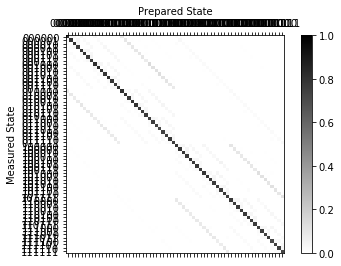

In [64]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

### For test
#backend = BasicAer.get_backend('qasm_simulator')
###

qr = QuantumRegister(6, 'qr')
### create and execute the calibration circuits
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')
job = execute(meas_calibs, backend=backend, shots=1024)
lapse = 0
interval = 30
while job.status() != JobStatus.DONE:
    print('Status @ {} seconds'.format(interval * lapse))
    print(job.status())
    time.sleep(interval)
    lapse += 1
print(job.status())
cal_results = job.result()
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
#print(meas_fitter.cal_matrix)
meas_fitter.plot_calibration()

Status @ 0 seconds
JobStatus.INITIALIZING
Status @ 30 seconds
JobStatus.QUEUED
Status @ 60 seconds
JobStatus.QUEUED
Status @ 90 seconds
JobStatus.QUEUED
Status @ 120 seconds
JobStatus.QUEUED
Status @ 150 seconds
JobStatus.QUEUED
Status @ 180 seconds
JobStatus.QUEUED
Status @ 210 seconds
JobStatus.QUEUED
Status @ 240 seconds
JobStatus.QUEUED
Status @ 270 seconds
JobStatus.QUEUED
Status @ 300 seconds
JobStatus.QUEUED
Status @ 330 seconds
JobStatus.QUEUED
Status @ 360 seconds
JobStatus.QUEUED
Status @ 390 seconds
JobStatus.QUEUED
Status @ 420 seconds
JobStatus.QUEUED
Status @ 450 seconds
JobStatus.QUEUED
Status @ 480 seconds
JobStatus.QUEUED
Status @ 510 seconds
JobStatus.QUEUED
Status @ 540 seconds
JobStatus.QUEUED
Status @ 570 seconds
JobStatus.QUEUED
Status @ 600 seconds
JobStatus.QUEUED
Status @ 630 seconds
JobStatus.QUEUED
Status @ 660 seconds
JobStatus.QUEUED
Status @ 690 seconds
JobStatus.QUEUED
Status @ 720 seconds
JobStatus.QUEUED
Status @ 750 seconds
JobStatus.QUEUED
Status @ 78

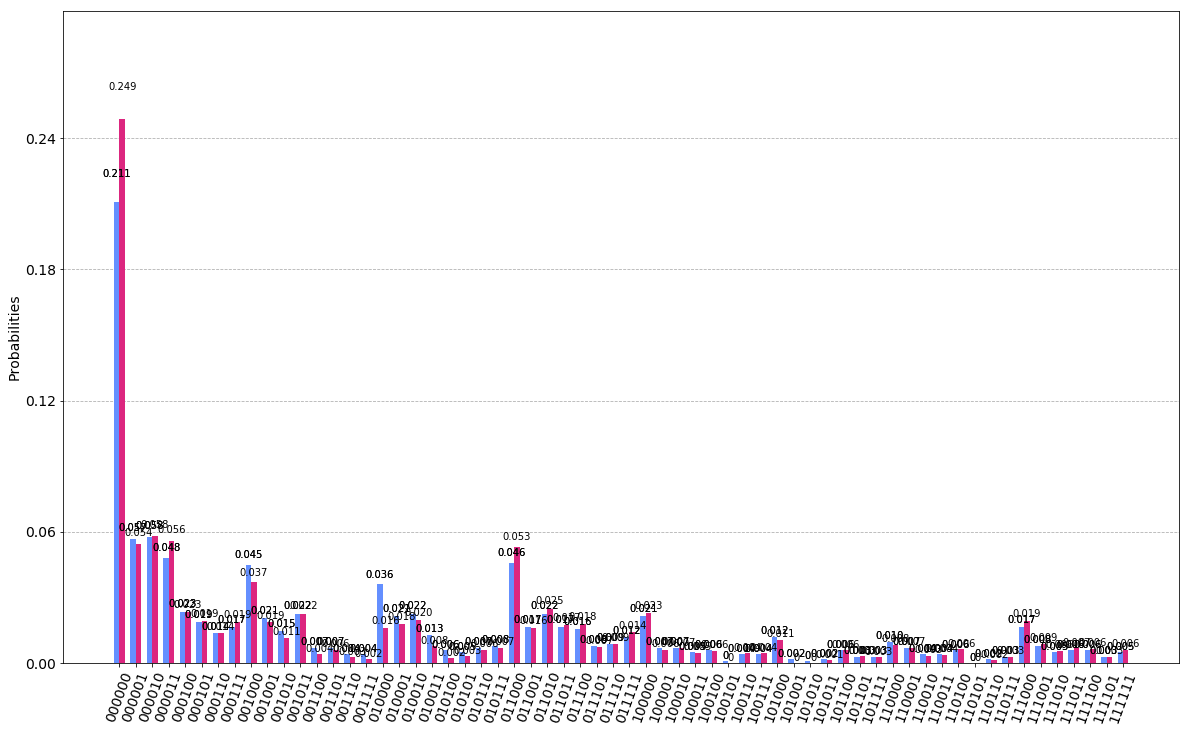

In [66]:
# 2 triangle plaquettes
#backend = BasicAer.get_backend('qasm_simulator')
T = 0.1
H = TrianglePlaquetteHamiltonian(0.5, 1, 2)
# Construct Circuit with n_steps = 20
qr = QuantumRegister(6, 'qr')
cr = ClassicalRegister(6, 'cr')

circ1 = QuantumCircuit(qr, cr)
circ1 = H.trotter_circuit_optimized(circ1, qr, T, 1)
circ1.measure(qr, cr)
job = execute(circ1, backend, shots=1024)
lapse = 0
interval = 30
while job.status() != JobStatus.DONE:
    print('Status @ {} seconds'.format(interval * lapse))
    print(job.status())
    time.sleep(interval)
    lapse += 1
print(job.status())
result_sim = job.result()
tr_dist = result_sim.get_counts(circ1)


# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(result_sim)
mitigated_counts = mitigated_results.get_counts(0)

plot_histogram([tr_dist, mitigated_counts] , figsize=(20, 12))

In [79]:
backend = BasicAer.get_backend('qasm_simulator')
job = execute(circ1, backend, shots=1024)
result_sim = job.result()
ideal_dist = result_sim.get_counts(circ1)
p1 = np.fromiter(tr_dist.values(), float)/1024
p2 = np.fromiter([ideal_dist.get(k, 0) for k in tr_dist.keys()], float)/1024
print(ideal_dist)
print(KL(p1, p2))
print(Shannon(p1))
print(Shannon(p2))
p1 = np.fromiter(mitigated_counts.values(), float)/1024
print(KL(p1, p2))
print(Shannon(p1))
print(Shannon(p2))

{'000000': 936, '111111': 1, '000111': 39, '111000': 48}
-0.3324641882509145
3.4194245547263185
0.3568149318634559
-0.014038488525536828
3.2860614222886033
0.3568149318634559


c:\users\kwibu\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
c:\users\kwibu\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
c:\users\kwibu\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':


In [78]:
valid_gauge = [dec_to_binary_str(idx, 6) for idx in np.arange(10)*7]
prob_gsect = np.sum(np.fromiter([tr_dist.get(key, 0) for key in valid_gauge], float)/1024)
prob_gsect_mitigated = np.sum(np.fromiter([mitigated_counts.get(key, 0) for key in valid_gauge], float)/1024)
print(prob_gsect)
print(prob_gsect_mitigated)

0.2861328125
0.327620613500636
